# Code from https://www.kaggle.com/models/keras/distil_bert

In [17]:
!pip install keras-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.8 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [1]:
import pandas as pd

subsample = pd.read_csv('subsample_with_img.csv', index_col=0)

In [2]:
import keras
import keras_hub
import numpy as np

In [4]:
from sklearn.model_selection import train_test_split

X = subsample[['clean_title']]
y = subsample[['2_way_label']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [16]:
features = list(X_train['clean_title'])
labels = list(y_train['2_way_label'])

# Use a shorter sequence length.
preprocessor = keras_hub.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_en",
    sequence_length=128,
)
# Pretrained classifier.
classifier = keras_hub.models.DistilBertClassifier.from_preset(
    "distil_bert_base_en",
    num_classes=2,
    preprocessor=preprocessor,
)
classifier.fit(x=features, y=labels, batch_size=2)

# Re-compile (e.g., with a new learning rate)
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(5e-5),
    jit_compile=True,
)
# Access backbone programmatically (e.g., to change `trainable`).
classifier.backbone.trainable = False
# Fit again.
classifier.fit(x=features, y=labels, batch_size=2)


466/466 ━━━━━━━━━━━━━━━━━━━━ 74s 84ms/step - loss: 0.6845 - sparse_categorical_accuracy: 0.5933
466/466 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - loss: 0.5643 - sparse_categorical_accuracy: 0.7132


In [18]:
preds = classifier.predict(list(X_test['clean_title']))

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step


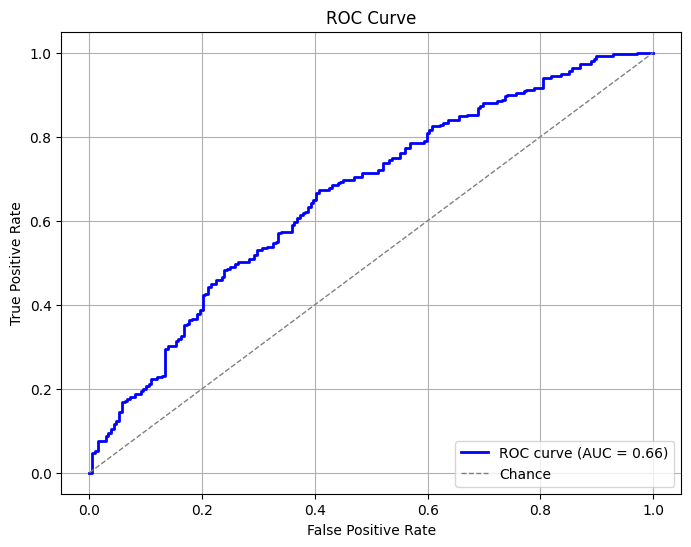

In [22]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Example DataFrame
data = {
    'TrueLabel': list(y_test['2_way_label']),
    'Scores': list(preds[:, 1])
}
df = pd.DataFrame(data)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(df['TrueLabel'], df['Scores'])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, label='Chance')

# Customize the plot
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


In [24]:
y_test['bert_score'] = preds[:, 1]

In [25]:
y_test

,2_way_label,bert_score
942,0,-0.571089
180,1,1.580122
1079,0,0.241635
1430,0,1.250819
1171,0,1.243760
...,...,...
1917,0,0.402701
1657,0,1.239460
1442,1,0.564928
803,1,0.169560


In [26]:
y_test.to_csv('bert_scores.csv')